# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_octubre_2018/conjunto_entrenamiento_octubre_2018_red_pitch5mm_rad161mm_total.mat')
conjunto_datos= datos_matlab.get('photodefA')
conjunto_datos.shape

(66498, 640)

In [3]:
import os
import pandas as pd
dir_name='../datos_octubre_2018'
base_filename='p_OF_5mm_161mm'
filename_suffix='.h5'
file=os.path.join(dir_name, base_filename+ "{0:03d}".format(0) + filename_suffix)
conjunto_datos_waves=pd.read_hdf(file,'MC')
datos_waves=conjunto_datos_waves.values
datos_waves.shape

(6320, 3840)

In [4]:
for i in range(1,2):
    file=os.path.join(dir_name, base_filename+ "{0:03d}".format(i) + filename_suffix)
    #print(file)
    veamos=pd.read_hdf(file,'MC')
    veamos_array=veamos.values
    datos_waves=np.concatenate((datos_waves,veamos_array),axis=0)
datos_waves.shape

(12641, 3840)

In [5]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
# input image dimensions
img_rows, img_cols = 16, 40

X_trained=datos_waves;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;

print(x_trained.shape)


(12641, 3840)


In [6]:
input_output_dim_A=img_rows*img_cols
ideaA=np.zeros((L1A,input_output_dim_A))

conjunto_datos=np.zeros((x_trained.shape[0]*L1A,input_output_dim_A))
for i in range(x_trained.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_trained[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    conjunto_datos[(i)*L1A :(i+1)*L1A,:] = ideaA    
    

  

## Network parameters:

In [7]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dim = 320  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_img = Input(shape=(img_rows*img_cols,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh', use_bias=False,bias_initializer='random_uniform')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_cols*img_rows, activation='tanh',use_bias=True,bias_initializer='random_uniform')(encoded)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoder = Model(input_img, decoded)

## Prepare data into training and test set.

In [8]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

75846
conjunto_datos shape: (75846, 640)
45507
15169
15170


In [9]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [10]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (45507, 40, 16, 1)
45507 train samples
15169 validation samples
15170 test samples


Display 20 random training images using image

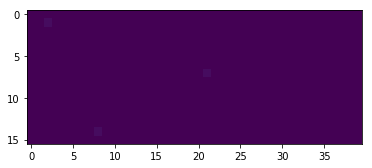

7467


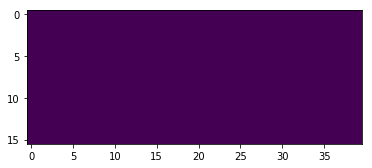

2501


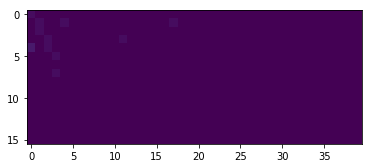

2689


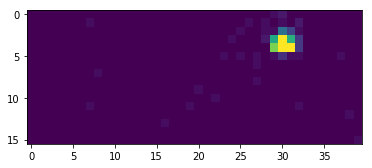

35804


In [11]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 40]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [12]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
prueba=x_train[0:15170,:]
print(x_train.shape)
print(x_test.shape)
print(prueba.shape)

(45507, 640)
(15170, 640)
(15170, 640)


In [13]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=100
factor_aprendizaje=0.0001
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(2*x_train/supermax)-1
x_test_scaled=(2*x_test/supermax)-1
#min_max_scaler.scale_
#x_train[29413]
#x_train_scaled[29413]

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [14]:
import keras.backend as KK
import keras.callbacks as KKcall
import tensorflow as tf

print (tf.VERSION)

1.5.0


In [15]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.argmax((y_val+1)*supermax/2, axis=1)
        y_predict = np.argmax((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()


In [16]:
def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [17]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoder.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [18]:
algoritmo='RMSprop'
experimento="scaled_{}_encoder_without_bias_tanh_tanh_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}{}{}{}".format(encoding_dim,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
history=autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=10000,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 45507 samples, validate on 15170 samples
Epoch 1/10000
45507/45507 [==============================] - 1s 28us/step - loss: 0.0629 - energy_error: 73.1017 - val_loss: 0.0012 - val_energy_error: 0.9013
Epoch 2/10000
45507/45507 [==============================] - 1s 18us/step - loss: 0.0014 - energy_error: 0.1417 - val_loss: 0.0012 - val_energy_error: -0.0164
Epoch 3/10000
45507/45507 [==============================] - 1s 19us/step - loss: 0.0014 - energy_error: -0.0389 - val_loss: 0.0012 - val_energy_error: -0.0304
Epoch 4/10000
45507/45507 [==============================] - 1s 21us/step - loss: 0.0014 - energy_error: -0.0424 - val_loss: 0.0012 - val_energy_error: -0.0286


KeyboardInterrupt: 

15170/15170 [==============================] - 1s 83us/step


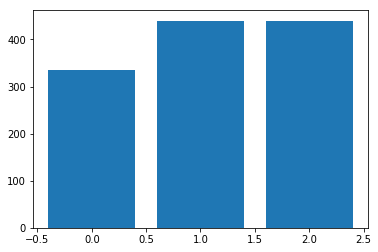

In [33]:
autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)
D=metrics.get_data()


data=pd.DataFrame(D).values.reshape(len(D))
valores=len(data)
plt.bar(range(valores),data), 

plt.show()

In [ ]:
for item in D:
    print(item['val_energy'])


In [ ]:
autoencoder.save_weights('../redes_compresoras/compresor_python_{}{}{}{}'.format(encoding_dim,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)

In [ ]:
standard_scores = encoder.predict(x_test_scaled).ravel()
#regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=True, label='standard model')
#sns.distplot(regularized_scores, hist=False, label='regularized model')

In [ ]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoder.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled+1)/2
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


In [ ]:
n = 6  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [ ]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_5mm_161mm003.h5'
conjunto_datos_test=pd.read_hdf(filename,'MC');
conjunto_datos_test.shape

In [ ]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
L1B=0;
# hay dos L1 con 640 sensores (40*16)
X_trained=conjunto_datos_test.values;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;
x_tested = x_trained;
print(x_trained.shape)
print(x_tested.shape)

# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [ ]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))

cara_externa=x_tested[:,0: L1A*input_output_dim_A] 
cara_externa_reconstruida=np.zeros((x_tested.shape[0],L1A*input_output_dim_A))
for i in range(x_tested.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_tested[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #ideaA_scaled=min_max_scaler.transform(ideaA)
    ideaA_scaled=(2*ideaA/(supermax)) -1
    salida_reconstructed_1_scaled = autoencoder.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled+1)/2
    #salida_reconstructed_1 = min_max_scaler.inverse_transform(salida_reconstructed_1_scaled)     
    #salida_reconstructed_1 = ideaA
    
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    #entrada_imgs_A=(ideaA) #he quitado el escalado
    #encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    #decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    #salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))

    #print(hola.shape)
    salida_total=hola1
    #salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

In [ ]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_tested.shape[0])
    idea=1890
    idea= 4299
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

In [ ]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
i=2
print(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:])
print(np.sum(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

In [ ]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:].astype(int))
print(np.sum(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

In [ ]:
print(idea)
np.sum(cara_externa_reconstruida,axis=0)

In [ ]:
veamos_energia=(np.sum(cara_externa_reconstruida, axis=1))-(np.sum(cara_externa, axis=1))
n, bins, patches = plt.hist(veamos_energia, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=200, cen=0, wid=100)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()